In [1]:
import os
import glob
import torch.utils.data as td
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

project_dir=os.path.expanduser('~/git/torchseg')
os.chdir(project_dir)

from dataset.fbms_dataset import fbms_dataset
from dataset.cdnet_dataset import cdnet_dataset
from dataset.dataset_generalize import image_normalizations
from utils.augmentor import Augmentations
from utils.torch_tools import get_ckpt_path,load_ckpt
from utils.disc_tools import get_diff,show_images,show_tensor_list
import argparse
from models.motionseg.motion_utils import get_parser,get_dataset
from utils.configs.motionseg_config import get_default_config
from utils.configs.semanticseg_config import load_config
from utils.notebook import get_model_and_dataset
from dataset.motionseg_dataset_factory import prepare_input_output

/home/yzbx/git/torchseg/models/motionseg/motion_backbone.py:101: UserWarning: unknown net name motion_diff for max extracted layer index
  warnings.warn('unknown net name {} for max extracted layer index'.format(config.net_name))
/home/yzbx/git/torchseg/models/motionseg/motion_diff.py:51: UserWarning: share backbone not worked for motion_diff
  warnings.warn('share backbone not worked for {}'.format(config.net_name))


use none layer******************************
train dataset size 2079
total dataset image 2079, use 1040
val dataset size 1376
total dataset image 1376, use 1376
no checkpoint file given, auto find /home/yzbx/tmp/logs/motion/motion_diff/DAVIS2016/test/2020-10-07___09-54-12/model-last-30.pkl
{'accumulate': 1, 'always_merge_flow': False, 'app': 'train', 'attention_type': 'c', 'aux_backbone': 'vgg11', 'aux_freeze': 3, 'aux_panet': False, 'backbone_freeze': False, 'backbone_name': 'vgg11', 'backbone_pretrained': True, 'batch_size': 4, 'checkpoint_path': None, 'class_number': 2, 'dataset': 'DAVIS2016', 'decode_main_layer': 1, 'deconv_layer': 5, 'epoch': 30, 'exception_value': 1.0, 'filter_feature': None, 'filter_relu': True, 'filter_type': 'main', 'frame_gap': 5, 'freeze_layer': 1, 'freeze_ratio': 0.0, 'fusion_type': 'all', 'gpu': 0, 'ignore_pad_area': 0, 'init_lr': 0.0001, 'input_format': 'ng', 'input_shape': [224, 224], 'layer_preference': 'last', 'log_dir': '/home/yzbx/tmp/logs/motion', '

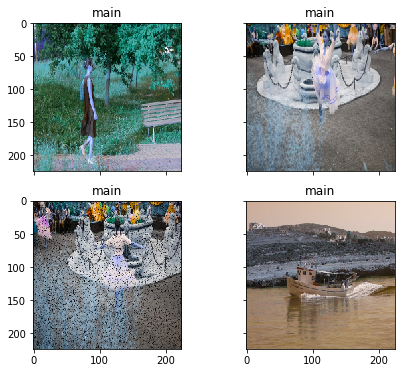

1 -0.06087614733393353 0.41147389395483286 1.0 -1.0


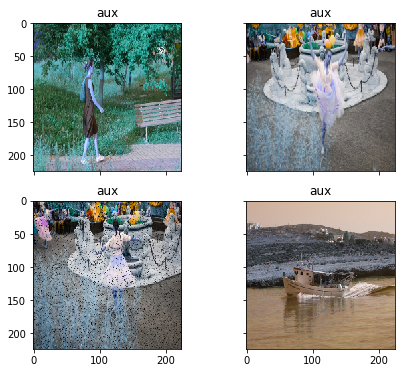

0 0.058469188456632654 0.23462852012885266 1 0


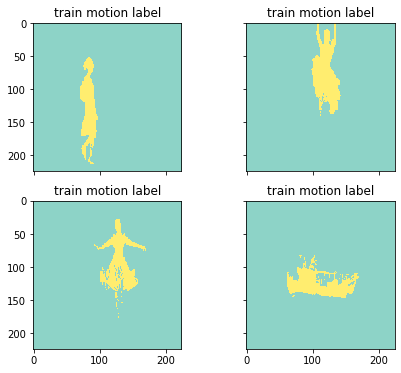

1 0.0604621731505102 0.238341139479587 1 0


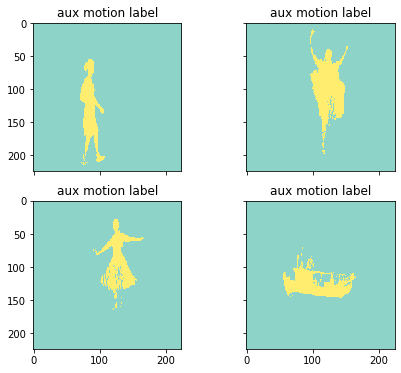

0 0.014454122 0.11935324 1.0 0.0


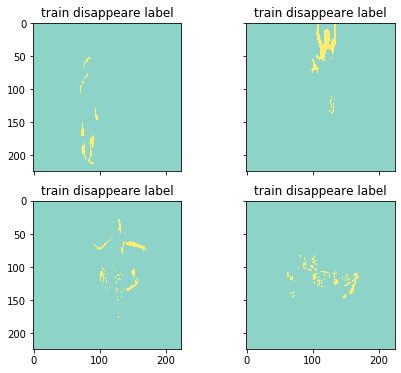

1 0.016447106 0.12718725 1.0 0.0


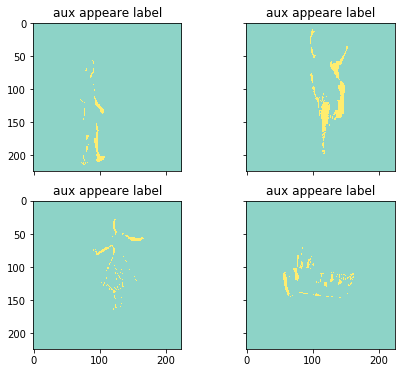

0 0.012675894 0.09590413 1.0 5.2448644e-15


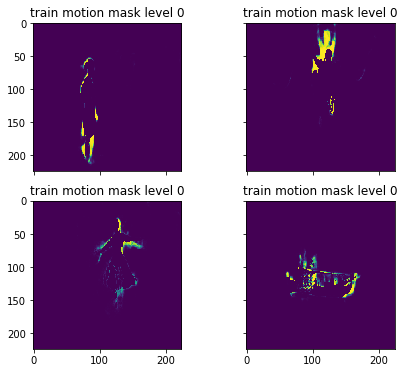

1 0.021167101 0.13244301 0.99993455 0.0


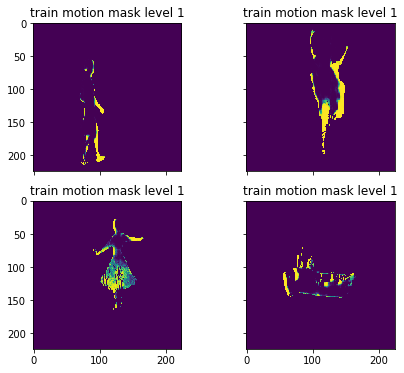

2 0.051481076 0.20704234 1.0 2.1925016e-06


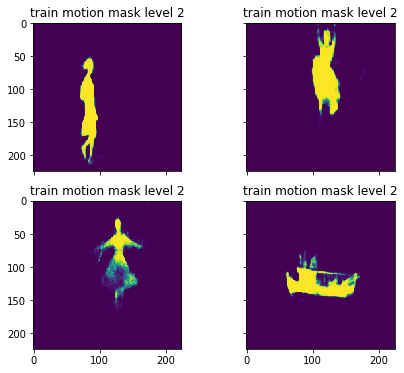

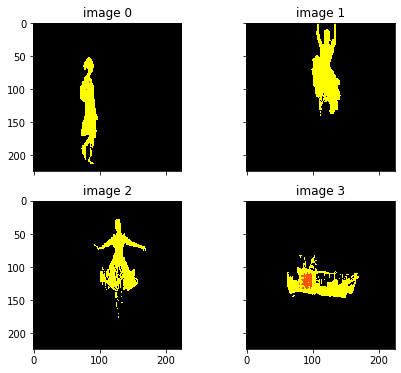

augmente validataion dataset ******************************
augmente validataion dataset ******************************
0 0.20292398209283713 0.5191654861410842 1.0 -1.0


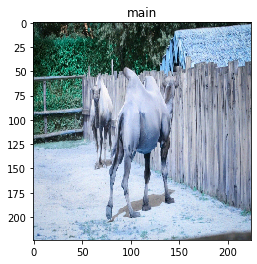

1 0.24073889972655724 0.5163184659486952 1.0 -0.9686274509803922


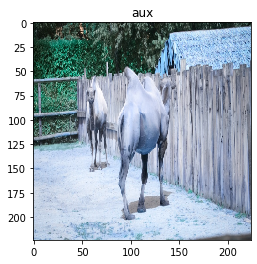

0 0.10973373724489796 0.31255758534255035 1 0


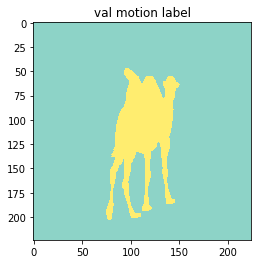

1 0.09755660076530612 0.29671418977262404 1 0


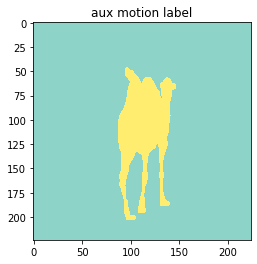

0 0.027802136 0.16440554 1.0 0.0


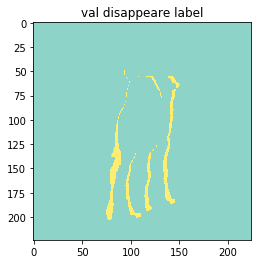

1 0.015625 0.12401959 1.0 0.0


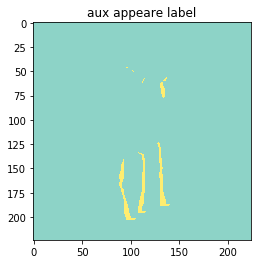

0 0.023223273 0.12839414 0.99918896 2.0552504e-08


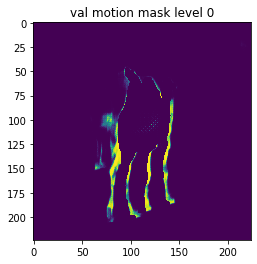

1 0.024785146 0.1438441 0.99996376 3.6977545e-19


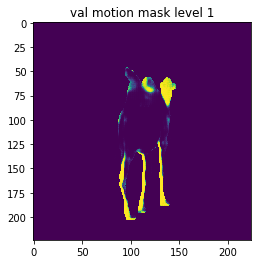

2 0.0967301 0.27943102 1.0 1.7745557e-05


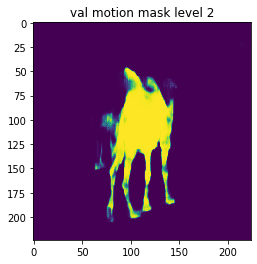

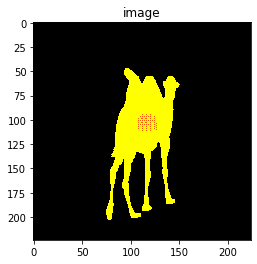

In [2]:
config_file='/home/yzbx/tmp/logs/motion/motion_diff/FBMS/test/2020-09-25___18-52-18/config.txt'
#config_file='/home/yzbx/tmp/logs/motion/motion_diff/cdnet2014/test/2020-09-25___19-16-21/config.txt'
#config_file='/home/yzbx/tmp/logs/motion/motion_diff/DAVIS2016/test/2020-10-06___12-48-59/config.txt'
config_list=load_config(config_file)
# config_list.filter_feature=None
model,dataset_loaders,normer=get_model_and_dataset(config_list)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()
#cmap=get_special_cmap('jet',{255:(1.0,0.0,0.0)})
import matplotlib.pyplot as plt
cmap=plt.get_cmap('Set3')
cmap.set_over('black')
cmap.set_bad('black')

print(model.config)
for split in ['train','val']:
    if split=='train':
        batch_size=config_list.batch_size
    else:
        batch_size=1
    for data in dataset_loaders[split]:
        images,origin_labels,resize_labels=prepare_input_output(data=data,config=config_list,device=device)
        outputs=model.forward(images)
        
        gt_plus=(resize_labels[0]-resize_labels[1]).clamp_(min=0)
        gt_minus=(resize_labels[1]-resize_labels[0]).clamp_(min=0)
        origin_images=data['images']
        show_tensor_list(origin_images,['main','aux'],normer)
        #origin_labels=[label[label==255]=0 for label in origin_labels]
        show_tensor_list(origin_labels,[split+' motion label','aux motion label'],vmin=0,vmax=1,cmap=cmap)
        show_tensor_list([gt_plus,gt_minus],[split+' disappeare label','aux appeare label'],vmin=0,vmax=1,cmap=cmap)

        assert len(outputs['masks'])==1
        masks=[torch.sigmoid(x) for x in torch.split(outputs['masks'][0],1,dim=1)]
        show_tensor_list(masks,[split+' motion mask level '+str(idx) for idx,t in enumerate(masks)])
        
        #show difference
        #note np.split is different from torch.split
        label=origin_labels[0].data.cpu().numpy()
        labels=[np.squeeze(l) for l in np.split(label,batch_size,0)]
        predicts=[np.squeeze(img.data.cpu().numpy()) for img in torch.split(masks[2],1,dim=0)]
        diff_images=[get_diff(img1.astype(np.uint8),(img2>=0.5).astype(np.uint8))[1] for img1,img2 in zip(labels,predicts)]
        show_images(diff_images,vmin=0,vmax=255,cmap=cmap)
        break

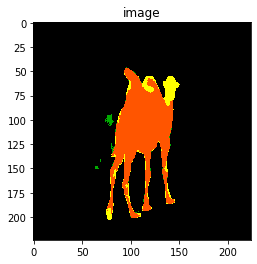

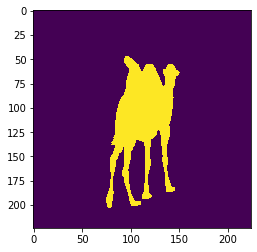

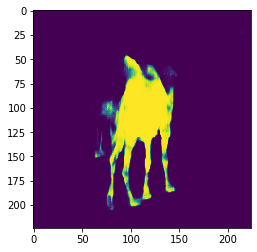

In [5]:
diff_images=[get_diff(img1.astype(np.uint8),(img2>=0.5).astype(np.uint8))[1] for img1,img2 in zip(labels,predicts)]
show_images(diff_images,vmin=0,vmax=255,cmap=cmap)
plt.imshow(labels[0])
plt.show()
plt.imshow(predicts[0])
plt.show()

# evalution 
- evaluation the predicttion of new area and loss area
- evaluation post-processing prediciton of foreground

In [17]:
from utils.metric.composite import CompositeMetric,MetricAcc
from tqdm import tqdm
#config_file='/home/yzbx/tmp/logs/motion/motion_diff/FBMS/test/2020-09-25___18-52-18/config.txt'
#config_file='/home/yzbx/tmp/logs/motion/motion_diff/cdnet2014/test/2020-09-25___19-16-21/config.txt'
#config_file='/home/yzbx/tmp/logs/motion/motion_diff/DAVIS2016/test/2020-10-06___12-48-59/config.txt'
# config_file='/home/yzbx/tmp/logs/motion/motion_diff/DAVIS2017/test/2020-10-06___18-26-40/config.txt'
config_file='/home/yzbx/tmp/logs/motion/motion_diff/DAVIS2016/twoframeonly/2020-10-12___10-54-55/config.txt'
config_list=load_config(config_file.strip())
# config_list.filter_feature=None
model,dataset_loaders,normer=get_model_and_dataset(config_list)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()
#cmap=get_special_cmap('jet',{255:(1.0,0.0,0.0)})
import matplotlib.pyplot as plt
cmap=plt.get_cmap('Set3')
cmap.set_over('black')
cmap.set_bad('black')

metrics=CompositeMetric()
metrics.add('origin_predict',MetricAcc())
metrics.add('post_predict',MetricAcc())
metrics.add('plus_predict',MetricAcc())
metrics.add('minus_predict',MetricAcc())

print(model.config)
result={}
for split in ['train','val']:
    metrics.reset()
    for data in tqdm(dataset_loaders[split]):
        images,origin_labels,resize_labels=prepare_input_output(data=data,config=config_list,device=device)
        outputs=model.forward(images)
        
        gt_plus=(resize_labels[0]-resize_labels[1]).clamp_(min=0)
        gt_minus=(resize_labels[1]-resize_labels[0]).clamp_(min=0)
        
        output=outputs['masks'][0]
        origin_predict=output[:,2:3,:,:]
        post_predict=output[:,2:3,:,:]+output[:,0:1,:,:]-output[:,1:2,:,:]
        plus_predict=output[:,2:3,:,:]+output[:,0:1,:,:]
        minus_predict=output[:,2:3,:,:]-output[:,1:2,:,:]
        
        metrics.update({"origin_predict":(origin_predict,resize_labels[0]),
                       "post_predict":(post_predict,resize_labels[0]),
                       "plus_predict":(plus_predict,resize_labels[0]),
                       "minus_predict":(minus_predict,resize_labels[0])})
        
        
#         current_metric=metrics.fetch()
#         print(current_metric)
    result[split]=metrics.fetch()

print(result)

  0%|          | 0/260 [00:00<?, ?it/s]

train dataset size 2079
total dataset image 2079, use 1040
val dataset size 1376
total dataset image 1376, use 1376
no checkpoint file given, auto find /home/yzbx/tmp/logs/motion/motion_diff/DAVIS2016/twoframeonly/2020-10-12___10-54-55/model-last-30.pkl
{'accumulate': 1, 'always_merge_flow': False, 'app': 'train', 'attention_type': 'c', 'aux_backbone': None, 'aux_freeze': 3, 'aux_panet': False, 'backbone_freeze': False, 'backbone_name': 'vgg11', 'backbone_pretrained': True, 'batch_size': 4, 'checkpoint_path': None, 'class_number': 2, 'dataset': 'DAVIS2016', 'decode_main_layer': 1, 'deconv_layer': 5, 'epoch': 30, 'exception_value': 1.0, 'filter_feature': None, 'filter_relu': True, 'filter_type': 'main', 'frame_gap': 5, 'freeze_layer': 1, 'freeze_ratio': 0.0, 'fusion_type': 'all', 'gpu': 0, 'ignore_pad_area': 0, 'init_lr': 0.0001, 'input_format': 'n', 'input_shape': [224, 224], 'layer_preference': 'last', 'log_dir': '/home/yzbx/tmp/logs/motion', 'loss_name': 'ce', 'main_panet': False, 'm

  0%|          | 0/1376 [00:00<?, ?it/s]

augmente validataion dataset ******************************
augmente validataion dataset ******************************


100%|██████████| 1376/1376 [00:42<00:00, 32.50it/s]

{'train': {'origin_predict': tensor(0.9760, device='cuda:0'), 'post_predict': tensor(0.9462, device='cuda:0'), 'plus_predict': tensor(0.8746, device='cuda:0'), 'minus_predict': tensor(0.7444, device='cuda:0')}, 'val': {'origin_predict': tensor(0.7414, device='cuda:0'), 'post_predict': tensor(0.7178, device='cuda:0'), 'plus_predict': tensor(0.5798, device='cuda:0'), 'minus_predict': tensor(0.5831, device='cuda:0')}}
